In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.products.vanilla_option import VanillaOption
from pricing.pricing.models.model_params import LewisParams, MCParams
from pricing.pricing.utility import from_1_delta_call_to_strike

from simulation.monte_carlo import MonteCarlo

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
%%time
ta = TensorAlgebra(dim=2, trunc=5)

Compiling...
Compilation finished.
CPU times: total: 5min 3s
Wall time: 5min 48s


In [3]:
N = 5
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e222 = ta.from_word("222", trunc=N)
e221 = ta.from_word("221", trunc=N)
e121 = ta.from_word("121", trunc=N)
e211 = ta.from_word("211", trunc=N)
e2222 = ta.from_word("2222", trunc=N)
e22222 = ta.from_word("22222", trunc=N)

In [406]:
rho = -0.85

vol_ts = e0 * 0.2 + e2 * 0.01 + e12 * (0.05) + e21 * 0.02 + e22 * 0.05

ta.print(vol_ts)

model = SigVol( 
    vol_ts=vol_ts, 
    ta=ta, 
    rho=rho
)

0.2*∅ + 0.01*2 + 0.05*12 + 0.02*21 + 0.05*22


## To Do:
- Implement localization for Malliavin ✅
- Implement delta from CF ✅
- Implement conditioning trick ✅
- Implement $D_s \Sigma_t$
- Implement formulae using $D^W$
  
## To test:
- Standard case (big TTM, rho ~ -0.5)
- Short maturities
- Correlations close to -1
- Compare for vanilla calls and digital calls ✅


Text(0.5, 1.0, 'Vol trajectories')

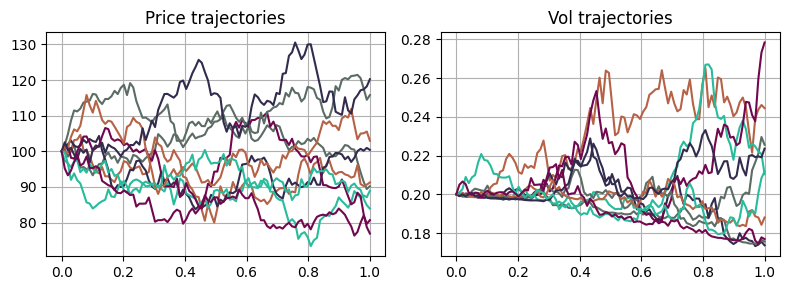

In [407]:
T = 1
F0 = 100

size = 10
N_grid = 100

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

In [408]:
%%time
size = 10**4

rng = np.random.default_rng(seed=21)
prices, vols, bm, sig = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, 
                                                   return_vol=True, return_bm=True, return_sig=True)

rho_bar = np.sqrt(1 - model.rho**2)

B = bm[:, 0, :]
W = bm[:, 1, :]
W_ort = (B - model.rho * W) / rho_bar

CPU times: total: 2.34 s
Wall time: 2.47 s


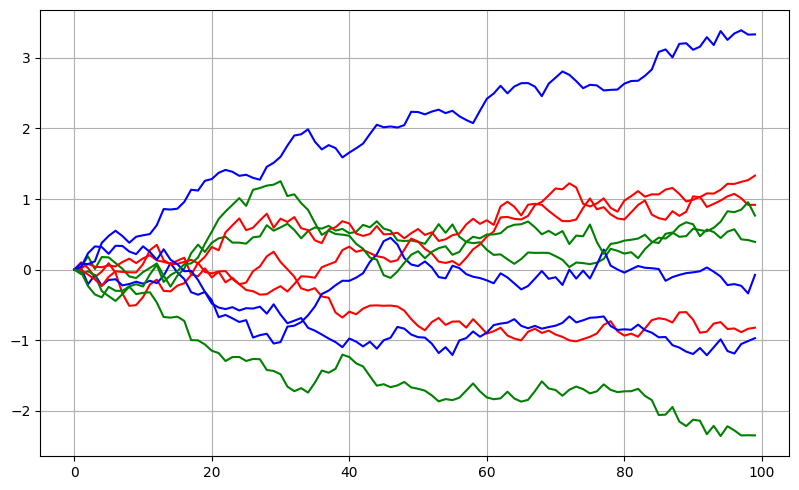

In [409]:
for i in range(3):
    plt.plot(W_ort[i], "r")
    plt.plot(W[i], "b")
    plt.plot(B[i], "g")

### Implementation of $D_s\langle v, \hat{\mathbb{W}}_t \rangle$

In [410]:
trunc = 5
n = 5

l_dict = {}
r_dict = {}
for i in range(ta.alphabet.number_of_elements(n)):
    v = ta.alphabet.index_to_word(i)
    if i == 0:
        l_dict[""] = ta.from_dict({}, trunc=trunc)
        r_dict[""] = ta.from_dict({}, trunc=trunc)
    else:
        l_first = l_dict[v[:-1]]
        r_first = r_dict[v[:-1]].tensor_prod_word(v[-1])
        new_shape = (l_first.shape[0], l_first.shape[1] + 1, l_first.shape[2])
        l_array = np.zeros(new_shape, dtype=complex)
        r_array = np.zeros(new_shape, dtype=complex)
        l_array[:, :-1, :] = l_first.array
        r_array[:, :-1, :] = r_first.array
        l_array[:, -1, :] = - l_first.shuffle_prod(r_first).array.sum(axis=1)
        if v[-1] == "2":
            v_prime_idx = ta.alphabet.word_to_index(v[:-1])
            l_array[v_prime_idx, -1, :] += 1
        r_array[0, -1, :] = 1
        l_dict[v] = ta.from_array(array=l_array, trunc=trunc)
        r_dict[v] = ta.from_array(array=r_array, trunc=trunc)

In [411]:
%%time
sigma_indices = model.vol_ts.array.squeeze().real
non_zero_indices = np.where(sigma_indices != 0)[0]

D_s_Sigma_t = np.zeros((size, t_grid.size, t_grid.size))

for i in non_zero_indices:
    v = ta.alphabet.index_to_word(i)
    if v == "∅":
        v = ""
    print(v, i, sigma_indices[i])
    l_sig = np.einsum("nkm,nj->kjm", sig.array, l_dict[v].array[:, :, 0]).real
    r_sig = np.einsum("nkm,nj->kjm", sig.array, r_dict[v].array[:, :, 0]).real
    D_s_Sigma_t += np.einsum("kjm,ljm->mkl", l_sig, r_sig) * sigma_indices[i]

 0 0.2
2 2 0.01
12 4 0.05
21 5 0.02
22 6 0.05
CPU times: total: 19.5 s
Wall time: 20.4 s


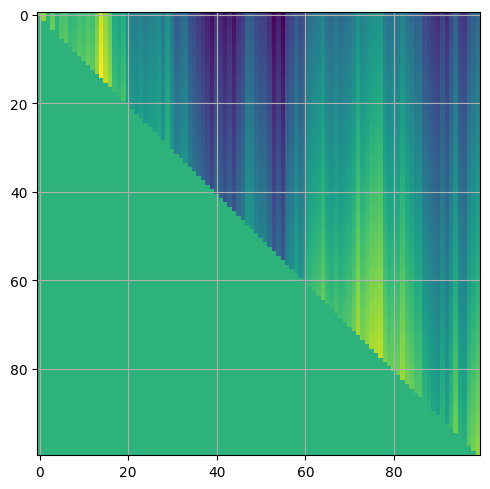

In [412]:
D_s_Sigma_t = np.triu(D_s_Sigma_t)
plt.imshow(D_s_Sigma_t[0])

In [413]:
G = -np.einsum("mkl,ml->mk", D_s_Sigma_t[:, :, :-1], np.diff(t_grid) * vols[:, :-1]) + \
    np.einsum("mkl,ml->mk", D_s_Sigma_t[:, :, :-1], np.diff(B, axis=1)) + \
    rho * vols

## Implementation of $\kappa$ and $\gamma$

In [414]:
trunc = 5
n = 5

kappa_dict = {}
gamma_dict = {}

kappa_array = np.zeros((ta.alphabet.number_of_elements(n), ta.alphabet.number_of_elements(trunc)))
gamma_array = np.zeros((ta.alphabet.number_of_elements(n), ta.alphabet.number_of_elements(trunc)))

for i in range(ta.alphabet.number_of_elements(n)):
    v = ta.alphabet.index_to_word(i)
    if i == 0:
        kappa_dict[""] = ta.from_dict({}, trunc=trunc)
        gamma_dict[""] = ta.from_dict({}, trunc=trunc)
    else:
        kappa_dict[v] = kappa_dict[v[:-1]].tensor_prod_word(v[-1]) + ta.from_dict({v[:-1] + "1": int(v[-1] == "2")}, trunc=trunc)
        gamma_dict[v] = gamma_dict[v[:-1]].tensor_prod_word(v[-1]) + kappa_dict[v[:-1]].tensor_prod_word("1") * int(v[-1] == "2")
        print("v = ", v)
        print("kappa(v) = ", )
        ta.print(kappa_dict[v])
        print("gamma(v) = ", )
        ta.print(gamma_dict[v])
        
        kappa_array[i] = kappa_dict[v].array.squeeze().real
        gamma_array[i] = gamma_dict[v].array.squeeze().real

v =  1
kappa(v) = 

gamma(v) = 

v =  2
kappa(v) = 
1.0*1
gamma(v) = 

v =  11
kappa(v) = 

gamma(v) = 

v =  12
kappa(v) = 
1.0*11
gamma(v) = 

v =  21
kappa(v) = 
1.0*11
gamma(v) = 

v =  22
kappa(v) = 
1.0*12 + 1.0*21
gamma(v) = 
1.0*11
v =  111
kappa(v) = 

gamma(v) = 

v =  112
kappa(v) = 
1.0*111
gamma(v) = 

v =  121
kappa(v) = 
1.0*111
gamma(v) = 

v =  122
kappa(v) = 
1.0*112 + 1.0*121
gamma(v) = 
1.0*111
v =  211
kappa(v) = 
1.0*111
gamma(v) = 

v =  212
kappa(v) = 
1.0*112 + 1.0*211
gamma(v) = 
1.0*111
v =  221
kappa(v) = 
1.0*121 + 1.0*211
gamma(v) = 
1.0*111
v =  222
kappa(v) = 
1.0*122 + 1.0*212 + 1.0*221
gamma(v) = 
1.0*112 + 1.0*121 + 1.0*211
v =  1111
kappa(v) = 

gamma(v) = 

v =  1112
kappa(v) = 
1.0*1111
gamma(v) = 

v =  1121
kappa(v) = 
1.0*1111
gamma(v) = 

v =  1122
kappa(v) = 
1.0*1112 + 1.0*1121
gamma(v) = 
1.0*1111
v =  1211
kappa(v) = 
1.0*1111
gamma(v) = 

v =  1212
kappa(v) = 
1.0*1112 + 1.0*1211
gamma(v) = 
1.0*1111
v =  1221
kappa(v) = 
1.0*1121 + 1.0*12

In [415]:
kappa_sigma = ta.from_array(trunc=trunc, array=vol_ts.array.squeeze().real @ kappa_array)
gamma_sigma = ta.from_array(trunc=trunc, array=vol_ts.array.squeeze().real @ gamma_array)

kappa_sigma_sq = kappa_sigma.shuffle_pow(2)

In [416]:
sig_T = sig[-1]

integrated_G = (sig_T @ (vol_ts.tensor_prod_word("1") * rho - vol_ts.shuffle_prod(kappa_sigma).tensor_prod_word("1"))).squeeze().real + \
               ((sig @ kappa_sigma)[:-1].real * np.diff(B.T, axis=0)).sum(axis=0)

integrated_DG = (sig_T @ (kappa_sigma.tensor_prod_word("1") * rho - kappa_sigma_sq.tensor_prod_word("1") / 2 - vol_ts.shuffle_prod(gamma_sigma).tensor_prod_word("1"))).squeeze().real + \
                ((sig @ gamma_sigma)[:-1].real * np.diff(B.T, axis=0)).sum(axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

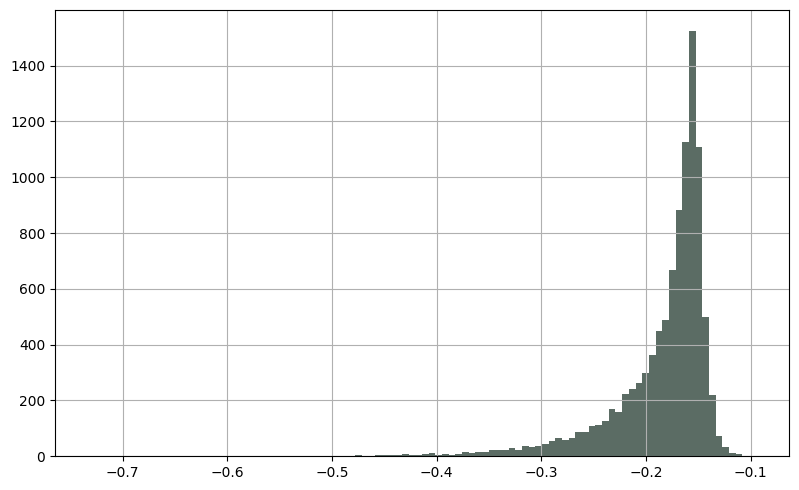

In [417]:
plt.hist(integrated_G, bins=100)
plt.show

### Payoffs

In [418]:
from scipy.stats import norm

def call_payoff(F, K):
    return np.maximum(F - K, 0)

def digital_call_payoff(F, K):
    return (F - K >= 0).astype(float)

## Localization (Vanilla Call)

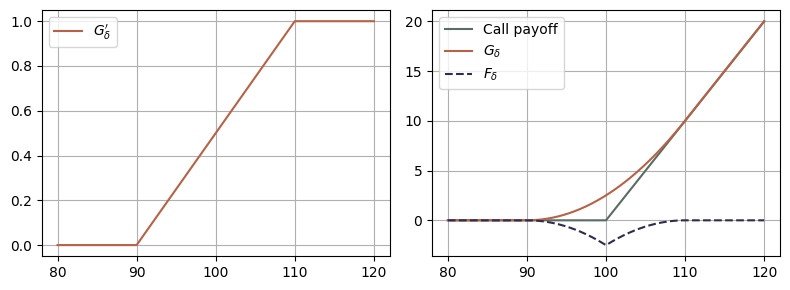

In [419]:
delta = 10
F_grid = np.linspace(80, 120, 1000)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

H_delta = lambda x, K: (x - (K - delta)) / (2 * delta) * (x >= K - delta) * (x <= K + delta) + (x > K + delta)
F_delta = lambda x, K: (-(x - (K - delta))**2 / (4 * delta)) * (x >= K - delta) * (x < K) + \
                       (-(x - (K + delta))**2 / (4 * delta)) * (x >= K) * (x < K + delta)

ax[0].plot(F_grid, H_delta(F_grid, K=F0), label="$G_\delta'$", color=my_copper)
ax[0].legend()


ax[1].plot(F_grid, call_payoff(F_grid, K=F0), label="Call payoff")
ax[1].plot(F_grid, np.cumsum(H_delta(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[1].plot(F_grid, F_delta(F_grid, K=F0), "--", label="$F_\delta$")

ax[1].legend()

## Computing Delta of ATM vanilla call option

In [420]:
confidence = 0.95

### Characteristic function

In [421]:
%%time

from scipy.special import roots_laguerre

N_points = 60

maturity = T
strikes = np.array([F0])
k = np.log(F0 / strikes)
z_arr, w_arr = roots_laguerre(n=N_points)

z_arr = np.reshape(z_arr, (-1, 1))
integrand_arr = (1j * (z_arr - 0.5 * 1j) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * (
        model.characteristic_function(T=maturity, x=0, u1=z_arr - 1j / 2).reshape((-1, 1))
) / (z_arr ** 2 + 0.25)).real
integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr

delta_cf = 1 - strikes / F0 / np.pi * integral
print(delta_cf)

mc_cf = MonteCarlo(batch=delta_cf * np.ones(size), confidence_level=confidence)

[0.56697745]
CPU times: total: 2.78 s
Wall time: 3.03 s


c:\users\dm6579\onedrive - engie\projects\simulation\simulation\monte_carlo.py:98: RuntimeWarning: invalid value encountered in sqrt
  self.accuracy = quantile * np.sqrt(self.var / self.batch_size / self.n_batch)


### Finite difference with $\epsilon = 1\%$ bump

In [422]:
eps = 0.01
price_bump_plus = prices * (1 + eps)
price_bump_minus = prices * (1 - eps)

In [423]:
batch_fd = (call_payoff(price_bump_plus[:, -1], F0) - call_payoff(price_bump_minus[:, -1], F0)) / (2 * eps * F0)
mc_fd = MonteCarlo(batch=batch_fd, confidence_level=confidence)

### Conditioning + BS Delta

In [424]:
def bs_delta(S0, K, T, sigma, r):
    d_plus = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d_plus)

In [425]:
U = (sig @ ta.shuop.shuffle_pow(model.vol_ts, 2).tensor_prod(e1)).real[-1]
Z = (sig @ (model.vol_ts.tensor_prod(e2) - model.vol_ts.proj("2").tensor_prod(e1) / 2)).real[-1]

sigma_bs = rho_bar * np.sqrt(U / T)
r_bs = (rho * Z - 0.5 * rho**2 * U) / T

batch_delta_bs = bs_delta(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_delta_bs = MonteCarlo(batch=batch_delta_bs, confidence_level=0.95)

In [426]:
mc_delta_bs.results()

'0.5677 ± 0.00861'

## Malliavin weights

In [427]:
payoff = call_payoff
F = F_delta
H = H_delta

### Malliavin $D$ with $h_t \equiv 1$

In [428]:
np.quantile(weight_D1, 0.001)

-1407.438679246391

In [429]:
weight_D1 = (1 / F0) * (W[:, -1] / integrated_G + integrated_DG / integrated_G**2)
# weight_D1 = np.maximum(weight_D1, np.quantile(weight_D1, 0.003))
# weight_D1 = np.minimum(weight_D1, np.quantile(weight_D1, 1 - 0.003))

batch_mal_D1 = payoff(prices[:, -1], F0) * weight_D1
mc_mal_D1 = MonteCarlo(batch=batch_mal_D1, confidence_level=0.95)

batch_mal_D1_loc = F(prices[:, -1], K=F0) * weight_D1 + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_D1_loc = MonteCarlo(batch=batch_mal_D1_loc, confidence_level=0.95)

<function matplotlib.pyplot.show(close=None, block=None)>

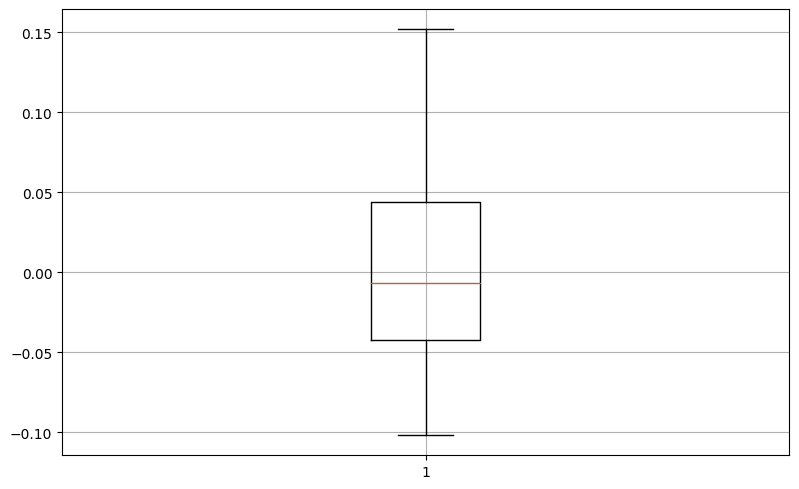

In [430]:
plt.boxplot(weight_D1)
plt.show

### Malliavin $D^\perp$ with $h_t \equiv 1$

In [431]:
weight_1 = W_ort[:, -1] / F0 / rho_bar / (sig @ model.vol_ts.tensor_prod(e1))[-1].real

batch_mal_1 = payoff(prices[:, -1], F0) * weight_1
mc_mal_1 = MonteCarlo(batch=batch_mal_1, confidence_level=0.95)

batch_mal_1_loc = F(prices[:, -1], K=F0) * weight_1 + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_loc = MonteCarlo(batch=batch_mal_1_loc, confidence_level=0.95)

### Malliavin $D^\perp$ with $h_t \equiv \dfrac{1}{\Sigma_t}$

In [432]:
weight_1_over_sigma = np.sum(np.diff(W_ort, axis=1) / vols[:, :-1], axis=1) / (rho_bar * T * F0)

batch_mal_1_over_sigma = payoff(prices[:, -1], F0) * weight_1_over_sigma
mc_mal_1_over_sigma = MonteCarlo(batch=batch_mal_1_over_sigma, confidence_level=0.95)

batch_mal_1_over_sigma_loc = F(prices[:, -1], K=F0) * weight_1_over_sigma + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_over_sigma_loc = MonteCarlo(batch=batch_mal_1_over_sigma_loc, confidence_level=0.95)

### Malliavin $D^\perp$ with $h_t \equiv {\Sigma_t}$

In [433]:
%%time
weight_sigma = np.sum(np.diff(W_ort, axis=1) * vols[:, :-1], axis=1) / U / (rho_bar * F0)

batch_mal_sigma = payoff(prices[:, -1], F0) * weight_sigma
mc_mal_sigma = MonteCarlo(batch=batch_mal_sigma, confidence_level=0.95)

batch_mal_sigma_loc = F(prices[:, -1], K=F0) * weight_sigma + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_sigma_loc = MonteCarlo(batch=batch_mal_sigma_loc, confidence_level=0.95)

CPU times: total: 0 ns
Wall time: 9 ms


### Malliavin $D$ with $h_t = \dfrac{1}{G(t, T)}$

In [434]:
weight_1_over_G = np.sum(1 / G[:, :-1] * np.diff(W, axis=1), axis=1) / T / F0

batch_mal_1_over_G = payoff(prices[:, -1], F0) * weight_1_over_G
mc_mal_1_over_G = MonteCarlo(batch=batch_mal_1_over_G, confidence_level=0.95)

batch_mal_1_over_G_loc = F(prices[:, -1], K=F0) * weight_1_over_G + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_over_G_loc = MonteCarlo(batch=batch_mal_1_over_G_loc, confidence_level=0.95)

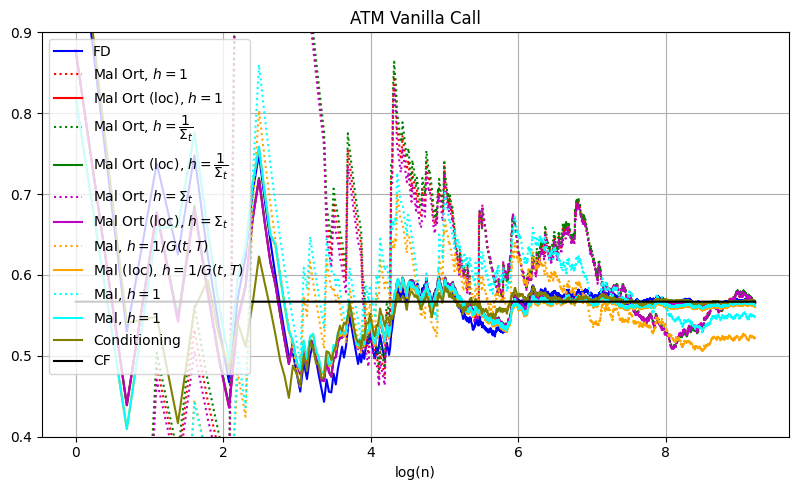

In [435]:
plot_interval = False

fig, ax = plt.subplots()

mc_fd.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, label="FD")

mc_mal_1.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", ls=":", label="Mal Ort, $h = 1$")
mc_mal_1_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", label="Mal Ort (loc), $h = 1$")

mc_mal_1_over_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", ls=":", label="Mal Ort, $h = \dfrac{1}{\Sigma_t}$")
mc_mal_1_over_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", label="Mal Ort (loc), $h = \dfrac{1}{\Sigma_t}$")

mc_mal_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", ls=":", label="Mal Ort, $h = {\Sigma_t}$")
mc_mal_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", label="Mal Ort (loc), $h = {\Sigma_t}$")

mc_mal_1_over_G.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="orange", ls=":", label="Mal, $h = {1 / G(t, T)}$")
mc_mal_1_over_G_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="orange", label="Mal (loc), $h = {1 / G(t, T)}$")

mc_mal_D1.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="cyan", ls=":", label="Mal, $h = 1$")
mc_mal_D1_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="cyan", label="Mal, $h = 1$")

mc_delta_bs.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="olive", label="Conditioning")

mc_cf.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="k", label="CF")

plt.ylim([0.4, 0.9])
plt.title("ATM Vanilla Call")
plt.show()

## Localization (Digital Call)

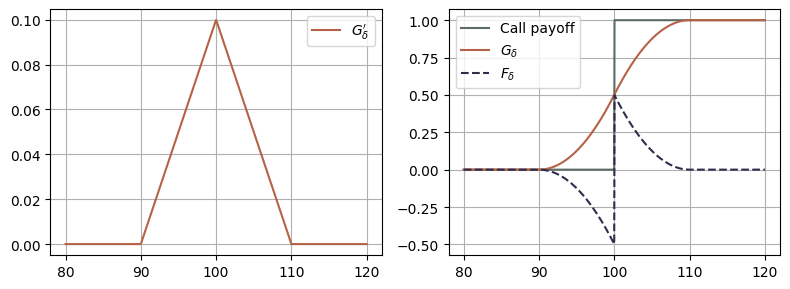

In [436]:
delta = 10
F_grid = np.linspace(80, 120, 1000)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

H_delta_dig = lambda x, K: (x - (K - delta)) / delta**2 * (x >= K - delta) * (x <= K) + \
                           ((K + delta) - x) / delta**2 * (x > K) * (x <= K + delta)
G_delta_dig = lambda x, K: ((x - (K - delta))**2 / (2 * delta**2)) * (x >= K - delta) * (x < K) + \
                           (1 - ((x - (K + delta))**2 / (2 * delta**2))) * (x >= K) * (x < K + delta) + (x >= K + delta)
F_delta_dig = lambda x, K: digital_call_payoff(x, K=K) - G_delta_dig(x, K=K)

ax[0].plot(F_grid, H_delta_dig(F_grid, K=F0), label="$G_\delta'$", color=my_copper)
ax[0].legend()


ax[1].plot(F_grid, digital_call_payoff(F_grid, K=F0), label="Call payoff")
ax[1].plot(F_grid, np.cumsum(H_delta_dig(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[1].plot(F_grid, F_delta_dig(F_grid, K=F0), "--", label="$F_\delta$")

ax[1].legend()

## Computing Delta of ATM vanilla call option

In [395]:
confidence = 0.95

### Characteristic function

In [396]:
%%time

from scipy.special import roots_laguerre

N_points = 60

maturity = T
strikes = np.array([F0])
k = np.log(F0 / strikes)
z_arr, w_arr = roots_laguerre(n=N_points)

z_arr = np.reshape(z_arr, (-1, 1))
integrand_arr = ((-z_arr * 1j + 0.5) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * (
        model.characteristic_function(T=maturity, x=0, u1=z_arr - 1j / 2).reshape((-1, 1))
) / (z_arr ** 2 + 0.25)).real
integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr

digital_price = 1 / np.pi * integral
print("Digital price", digital_price)

integrand_arr = (np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * (
        model.characteristic_function(T=maturity, x=0, u1=z_arr - 1j / 2).reshape((-1, 1))
)).real
integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr

delta_cf = 1 / np.pi / F0 * integral
print("Digital delta", delta_cf)

mc_cf = MonteCarlo(batch=delta_cf * np.ones(size), confidence_level=confidence)

Digital price [0.45748161]
Digital delta [0.0187777]
CPU times: total: 5.28 s
Wall time: 5.73 s


### Finite difference with $\epsilon = 1\%$ bump

In [397]:
eps = 0.01
price_bump_plus = prices * (1 + eps)
price_bump_minus = prices * (1 - eps)

In [398]:
payoff = digital_call_payoff
batch_fd = (payoff(price_bump_plus[:, -1], F0) - payoff(price_bump_minus[:, -1], F0)) / (2 * eps * F0)
mc_fd = MonteCarlo(batch=batch_fd, confidence_level=confidence)

In [399]:
mc_payoff = MonteCarlo(batch=payoff(prices[:, -1], F0), confidence_level=confidence)
mc_payoff.results()

'0.4574 ± 0.00976'

### Conditioning + BS Delta

In [400]:
def bs_digital(S0, K, T, sigma, r):
    d_minus = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d_minus) * np.exp(-r * T)

def bs_delta_digital(S0, K, T, sigma, r):
    d_minus = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d_minus) / (S0 * sigma * np.sqrt(T)) * np.exp(-r * T)

In [401]:
U = (sig @ ta.shuop.shuffle_pow(model.vol_ts, 2).tensor_prod(e1)).real[-1]
Z = (sig @ (model.vol_ts.tensor_prod(e2) - model.vol_ts.proj("2").tensor_prod(e1) / 2)).real[-1]

sigma_bs = rho_bar * np.sqrt(U / T)
r_bs = (rho * Z - 0.5 * rho**2 * U) / T

batch_delta_bs = bs_delta_digital(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_delta_bs = MonteCarlo(batch=batch_delta_bs, confidence_level=0.95)

In [402]:
batch_digital_bs = bs_digital(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_digital_bs = MonteCarlo(batch=batch_digital_bs, confidence_level=0.95)
mc_digital_bs.results()

'0.45753 ± 0.0001'

In [403]:
mc_delta_bs.results()

'0.0188 ± 4e-05'

### Malliavin

In [404]:
payoff = digital_call_payoff
F = F_delta_dig
H = H_delta_dig

### Malliavin $D$ with $h_t \equiv 1$

In [405]:
weight_D1 = (1 / F0) * (W[:, -1] / integrated_G + integrated_DG / integrated_G**2)
weight_D1 = np.maximum(weight_D1, np.quantile(weight_D1, 0.003))
weight_D1 = np.minimum(weight_D1, np.quantile(weight_D1, 1 - 0.003))

batch_mal_D1 = payoff(prices[:, -1], F0) * weight_D1
mc_mal_D1 = MonteCarlo(batch=batch_mal_D1, confidence_level=0.95)

batch_mal_D1_loc = F(prices[:, -1], K=F0) * weight_D1 + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_D1_loc = MonteCarlo(batch=batch_mal_D1_loc, confidence_level=0.95)

### Malliavin $D^\perp$ with $h_t \equiv 1$

In [347]:
%%time
weight_1 = W_ort[:, -1] / F0 / rho_bar / (sig @ model.vol_ts.tensor_prod(e1))[-1].real

batch_mal_1 = payoff(prices[:, -1], F0) * weight_1
mc_mal_1 = MonteCarlo(batch=batch_mal_1, confidence_level=0.95)

batch_mal_1_loc = F(prices[:, -1], K=F0) * weight_1 + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_loc = MonteCarlo(batch=batch_mal_1_loc, confidence_level=0.95)

CPU times: total: 422 ms
Wall time: 430 ms


### Malliavin $D^\perp$ with $h_t \equiv \dfrac{1}{\Sigma_t}$

In [348]:
%%time
weight_1_over_sigma = np.sum(np.diff(W_ort, axis=1) / vols[:, :-1], axis=1) / (rho_bar * T * F0)

batch_mal_1_over_sigma = payoff(prices[:, -1], F0) * weight_1_over_sigma
mc_mal_1_over_sigma = MonteCarlo(batch=batch_mal_1_over_sigma, confidence_level=0.95)

batch_mal_1_over_sigma_loc = F(prices[:, -1], K=F0) * weight_1_over_sigma + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_over_sigma_loc = MonteCarlo(batch=batch_mal_1_over_sigma_loc, confidence_level=0.95)

CPU times: total: 15.6 ms
Wall time: 15.5 ms


### Malliavin $D^\perp$ with $h_t \equiv {\Sigma_t}$

In [349]:
%%time
weight_sigma = np.sum(np.diff(W_ort, axis=1) * vols[:, :-1], axis=1) / U / (rho_bar * F0)

batch_mal_sigma = payoff(prices[:, -1], F0) * weight_sigma
mc_mal_sigma = MonteCarlo(batch=batch_mal_sigma, confidence_level=0.95)

batch_mal_sigma_loc = F(prices[:, -1], K=F0) * weight_sigma + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_sigma_loc = MonteCarlo(batch=batch_mal_sigma_loc, confidence_level=0.95)

CPU times: total: 0 ns
Wall time: 12.4 ms


### Malliavin $D$ with $h_t = \dfrac{1}{G(t, T)}$

In [350]:
%%time
weight_1_over_G = np.sum(1 / G[:, :-1] * np.diff(W, axis=1), axis=1) / T / F0

batch_mal_1_over_G = payoff(prices[:, -1], F0) * weight_1_over_G
mc_mal_1_over_G = MonteCarlo(batch=batch_mal_1_over_G, confidence_level=0.95)

batch_mal_1_over_G_loc = F(prices[:, -1], K=F0) * weight_1_over_G + H(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_over_G_loc = MonteCarlo(batch=batch_mal_1_over_G_loc, confidence_level=0.95)

CPU times: total: 15.6 ms
Wall time: 11 ms


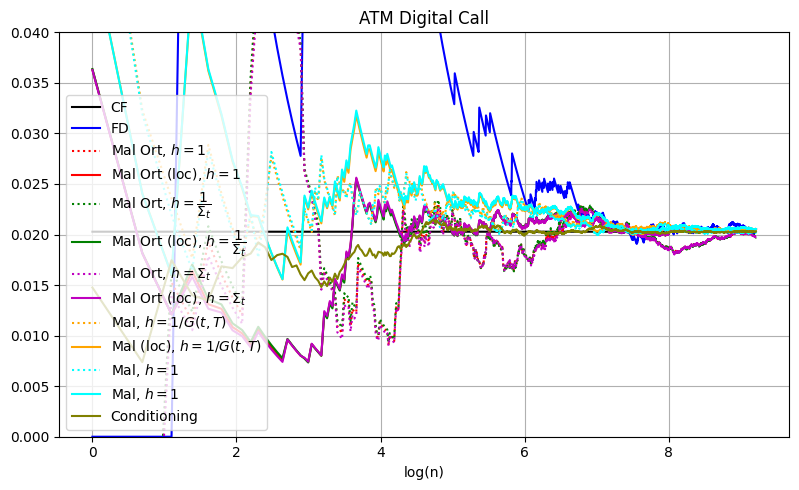

In [351]:
plot_interval = False

fig, ax = plt.subplots()

mc_cf.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="k", label="CF")

mc_fd.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, label="FD")

mc_mal_1.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", ls=":", label="Mal Ort, $h = 1$")
mc_mal_1_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", label="Mal Ort (loc), $h = 1$")

mc_mal_1_over_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", ls=":", label="Mal Ort, $h = \dfrac{1}{\Sigma_t}$")
mc_mal_1_over_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", label="Mal Ort (loc), $h = \dfrac{1}{\Sigma_t}$")

mc_mal_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", ls=":", label="Mal Ort, $h = {\Sigma_t}$")
mc_mal_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", label="Mal Ort (loc), $h = {\Sigma_t}$")

mc_mal_1_over_G.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="orange", ls=":", label="Mal, $h = {1 / G(t, T)}$")
mc_mal_1_over_G_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="orange", label="Mal (loc), $h = {1 / G(t, T)}$")

mc_mal_D1.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="cyan", ls=":", label="Mal, $h = 1$")
mc_mal_D1_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="cyan", label="Mal, $h = 1$")

mc_delta_bs.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="olive", label="Conditioning")

plt.ylim([0, 0.04])
plt.title("ATM Digital Call")
plt.show()